#  Load Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

# Any results you write to the current directory are saved as output.

# Some theory

Expected Loss (EL) on a given is calculuated using the loan amount multiplied by a loan's probability of default (PD) mulitplied by the the loan's loss given default (LGD). Loss Given Default is the amount of the loan that is deemed unrecoverable and is represented as a number between 0 (no loss) and 1 (100% of the loan is a loss)

The equation for EL is given as:

** EL = PD x LGD x Loan Amount*

After selected features using the 5 C's of Credit Framework and adjusting for the skewedness in the data (there is a greater proportion of loans in the portfolio that have NOT defaulted versus loans that HAVE defaulted) we will model proabilities of default using classification models. 


In [2]:
raw_data = pd.read_csv("loan.csv.zip",low_memory=False)
raw_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
preprocess_df = raw_data[['emp_length', 'loan_status', 'home_ownership', 'issue_d',
                          'earliest_cr_line', 'purpose', 'term', 'annual_inc', 'dti',
                          'loan_amnt', 'int_rate', 'pub_rec_bankruptcies',]].copy()

In [4]:
preprocess_df = raw_data[['emp_length', 'loan_status', 'home_ownership', 'issue_d',
                          'earliest_cr_line', 'purpose', 'term', 'annual_inc', 'dti',
                          'loan_amnt', 'int_rate', 'pub_rec_bankruptcies',]].copy()
# Create a list of columns that are NOT numeric values
not_numeric_cols = ['emp_length', 'loan_status', 'home_ownership', 'issue_d',
                    'earliest_cr_line', 'purpose', 'term']

# Create list of columns that ARE numeric values and print
numeric_cols = [col for col in preprocess_df.columns if col not in not_numeric_cols]
print(numeric_cols)

# Convert numeric cols into numeric data types
preprocess_df[numeric_cols] = preprocess_df[numeric_cols].apply(pd.to_numeric)

['annual_inc', 'dti', 'loan_amnt', 'int_rate', 'pub_rec_bankruptcies']


In [5]:
# Create list of datetime columns
datetime_cols = ['earliest_cr_line', 'issue_d']

# Convert to datetime
preprocess_df[datetime_cols] = preprocess_df[datetime_cols].apply(pd.to_datetime)

# Missing Data / Missing Observations

In [6]:
preprocess_df.isnull().sum()

emp_length              146907
loan_status                  0
home_ownership               0
issue_d                      0
earliest_cr_line            29
purpose                      0
term                         0
annual_inc                   4
dti                       1711
loan_amnt                    0
int_rate                     0
pub_rec_bankruptcies      1365
dtype: int64

# Character: pub_rec_bankruptcies, earliest_cr_line, issue_d
What it is: A lender’s opinion of a borrower’s general trustworthiness, credibility and personality. Not only the willingness of the oblgior to repay an obligation, and live up to its terms, but also honesty relative to the risk of fraud. 

Why it matters: Banks want to lend to people who are responsible and keep commitments.

How it’s assessed: From your work experience, credit history, credentials, references, reputation and interaction with lenders.

In [7]:
character_df = preprocess_df[['pub_rec_bankruptcies', 'earliest_cr_line', 'issue_d']].copy()

In [8]:
print(character_df.head())
print(character_df.describe())
print(character_df.dtypes)

   pub_rec_bankruptcies earliest_cr_line    issue_d
0                   1.0       2001-04-01 2018-12-01
1                   1.0       1987-06-01 2018-12-01
2                   0.0       2011-04-01 2018-12-01
3                   0.0       2006-02-01 2018-12-01
4                   0.0       2000-12-01 2018-12-01
       pub_rec_bankruptcies
count          2.259303e+06
mean           1.281935e-01
std            3.646130e-01
min            0.000000e+00
25%            0.000000e+00
50%            0.000000e+00
75%            0.000000e+00
max            1.200000e+01
pub_rec_bankruptcies           float64
earliest_cr_line        datetime64[ns]
issue_d                 datetime64[ns]
dtype: object


<code>'earliest_cr_line'</code> shows the first credit line on the customer credit report. 

Will create a new feature that shows the number of months between the first credit line in the customers history and the issue date of the loan.

In [9]:
# fill the missing value for earliest_cr_line with most frequently occuring
character_df['earliest_cr_line'].fillna(character_df['earliest_cr_line'].value_counts().index[0], inplace=True)

In [10]:
# count months between now and 'earliest_cr_line'
character_df['credit_hist_in_months'] = ((character_df['issue_d'] - character_df['earliest_cr_line'])/np.timedelta64(1, 'M'))
character_df['credit_hist_in_months'] = character_df['credit_hist_in_months'].astype(int)

character_df.head()

,pub_rec_bankruptcies,earliest_cr_line,issue_d,credit_hist_in_months
0,1.0,2001-04-01,2018-12-01,212
1,1.0,1987-06-01,2018-12-01,378
2,0.0,2011-04-01,2018-12-01,92
3,0.0,2006-02-01,2018-12-01,153
4,0.0,2000-12-01,2018-12-01,215


In [11]:
# Create a new binary feature of whether or not there is a bankruptcy on file in customers credit history
character_df['cb_person_bk_on_file_Y'] = character_df['pub_rec_bankruptcies'].apply(lambda x: 1 if x >= 1 else 0)
character_df.head()

,pub_rec_bankruptcies,earliest_cr_line,issue_d,credit_hist_in_months,cb_person_bk_on_file_Y
0,1.0,2001-04-01,2018-12-01,212,1
1,1.0,1987-06-01,2018-12-01,378,1
2,0.0,2011-04-01,2018-12-01,92,0
3,0.0,2006-02-01,2018-12-01,153,0
4,0.0,2000-12-01,2018-12-01,215,0


In [12]:
# drop the old features from the character_df
character_df.drop(['pub_rec_bankruptcies', 'earliest_cr_line', 'issue_d'], axis=1, inplace=True)
character_df.head()

,credit_hist_in_months,cb_person_bk_on_file_Y
0,212,1
1,378,1
2,92,0
3,153,0
4,215,0


# Capacity/Cash flow: annual_inc & dti
What it is: Your ability to repay the loan. The ability to generate cash to repay all oblgiations, when due. Assessing this is the primary goal of credit analysis

Why it matters: Lenders want to be assured that your business generates enough cash flow to repay the loan in full.

In [13]:
capacity_df = preprocess_df[['annual_inc', 'dti']].copy()
capacity_df.head()

,annual_inc,dti
0,55000.0,18.24
1,90000.0,26.52
2,59280.0,10.51
3,92000.0,16.74
4,57250.0,26.35


In [14]:
# fill missing values for annual income with the mean
capacity_df['annual_inc'] = capacity_df['annual_inc'].fillna(capacity_df['annual_inc'].mean())

# fill missing values for dti with the mean
capacity_df['dti'] = capacity_df['dti'].fillna(capacity_df['dti'].mean())

In [15]:
# describe the capacity/cash flow proxy features
print(capacity_df[['annual_inc', 'dti']].describe())

         annual_inc           dti
count  2.260668e+06  2.260668e+06
mean   7.799243e+04  1.882420e+01
std    1.126961e+05  1.417796e+01
min    0.000000e+00 -1.000000e+00
25%    4.600000e+04  1.190000e+01
50%    6.500000e+04  1.785000e+01
75%    9.300000e+04  2.448000e+01
max    1.100000e+08  9.990000e+02


# Conditions : loan_amnt, int_rate, term
What it is: The condition of a business/individual — whether it is growing or faltering — as well as what you’ll use the funds for. Refers to the macro-economic and competitive environment which will impact an obligor's future performance and its ability to generate cash. 

Why it matters: To ensure that loans are repaid, banks want to lend to businesses operating under favorable conditions. They aim to identify risks and protect themselves accordingly.

How it’s assessed: From a review of the competitive landscape, supplier and customer relationships, and macroeconomic and industry-specific issues.

In [16]:
conditions_df = preprocess_df[['loan_amnt', 'int_rate', 'term']].copy()

In [17]:
conditions_df.term.value_counts()

 36 months    1609754
 60 months     650914
Name: term, dtype: int64

In [18]:
# Convert values of term to 0, 1 where 0 = 36 months and 1 = 60 months
conditions_df['term'] = conditions_df['term'].replace({' 36 months': '0',
                                                       ' 60 months': '1'})

# convert term into an integer data type 
conditions_df['term'] = conditions_df['term'].astype(int)

# Rename term column
conditions_df = conditions_df.rename(columns={'term': 'term_60'})

print(conditions_df.term_60.value_counts())
conditions_df.head()

0    1609754
1     650914
Name: term_60, dtype: int64


,loan_amnt,int_rate,term_60
0,2500,13.56,0
1,30000,18.94,1
2,5000,17.97,0
3,4000,18.94,0
4,30000,16.14,1


# Collateral: home_ownership
What it is: Assets that are used to guarantee or secure a loan.

Why it matters: Collateral is a backup source if the borrower cannot repay a loan.

In [19]:
collateral_df = preprocess_df[['home_ownership']].copy()
collateral_df.head()

,home_ownership
0,RENT
1,MORTGAGE
2,MORTGAGE
3,MORTGAGE
4,MORTGAGE


In [20]:
# create emp_length dummy data frame
home_ownership = pd.DataFrame(pd.get_dummies(collateral_df['home_ownership'], prefix='home_ownership'))

# join the loan_amnt dummy dataframe to conditions_df
collateral_df = pd.concat([collateral_df, home_ownership], axis=1, sort=False)

# drop original emp_length feature
collateral_df.drop(['home_ownership'], axis=1, inplace=True)

collateral_df.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,0,0,0,0,0,1
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


# Loan Status

Current Status of the Loan. Target variable

In [21]:
loan_status_df = preprocess_df[['loan_status']].copy()
loan_status_df.loan_status.value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

In [22]:
loan_status_df['loan_status'] = loan_status_df['loan_status'].replace({'Fully Paid': 0, 'Current': 0, 'Charged Off': 1,
                                                                       'Late (31-120 days)': 1, 'In Grace Period': 1,
                                                                       'Late (16-30 days)':1,
                                                                       'Does not meet the credit policy. Status:Fully Paid': 0,
                                                                       'Does not meet the credit policy. Status:Charged Off': 1,
                                                                       'Default':1})
loan_status_df.loan_status.value_counts()

0    1963635
1     297033
Name: loan_status, dtype: int64

# Combine all the processed dataframes together into a single one

In [23]:
# Concatenate all the processed dataframes into a single one
processed_df = pd.concat([character_df,
                          capacity_df,
                          conditions_df,
                          collateral_df,
                          loan_status_df,
                          raw_data['grade']], axis=1, sort=False)
processed_df.head()

,credit_hist_in_months,cb_person_bk_on_file_Y,annual_inc,dti,loan_amnt,int_rate,term_60,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_status,grade
0,212,1,55000.0,18.24,2500,13.56,0,0,0,0,0,0,1,0,C
1,378,1,90000.0,26.52,30000,18.94,1,0,1,0,0,0,0,0,D
2,92,0,59280.0,10.51,5000,17.97,0,0,1,0,0,0,0,0,D
3,153,0,92000.0,16.74,4000,18.94,0,0,1,0,0,0,0,0,D
4,215,0,57250.0,26.35,30000,16.14,1,0,1,0,0,0,0,0,C


# Count total Non-Defualt and Defaulted Loans in the Data Set

Where 

'0' is a loan that has NOT defaulted 

and 

'1' is a loan that HAS defaulted

In [24]:
print(processed_df.loan_status.value_counts())

0    1963635
1     297033
Name: loan_status, dtype: int64


Text(0, 0.5, 'Number of Loans')

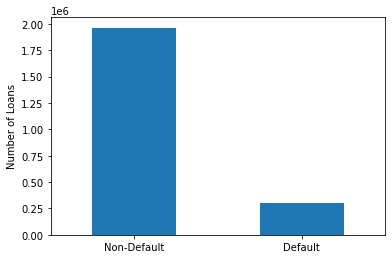

In [25]:
ax = processed_df.loan_status.value_counts().plot(kind='bar')
labels = ['Non-Default', 'Default']
ax.set_xticklabels(labels, rotation='horizontal')
ax.set_ylabel('Number of Loans')

 # EDA

### Defaults by Grade

Loans rated as "C" show the highest instances of defaults

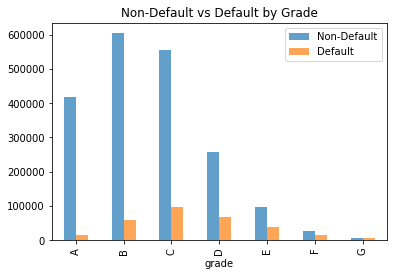

In [26]:
grade_default = pd.crosstab(processed_df['grade'], processed_df['loan_status'])

fig, ax = plt.subplots()

grade_default.plot.bar(legend=True, alpha=0.7, ax=ax)
plt.title("Non-Default vs Default by Grade")
ax.legend(["Non-Default", "Default"])

# Correlation in Credit Features

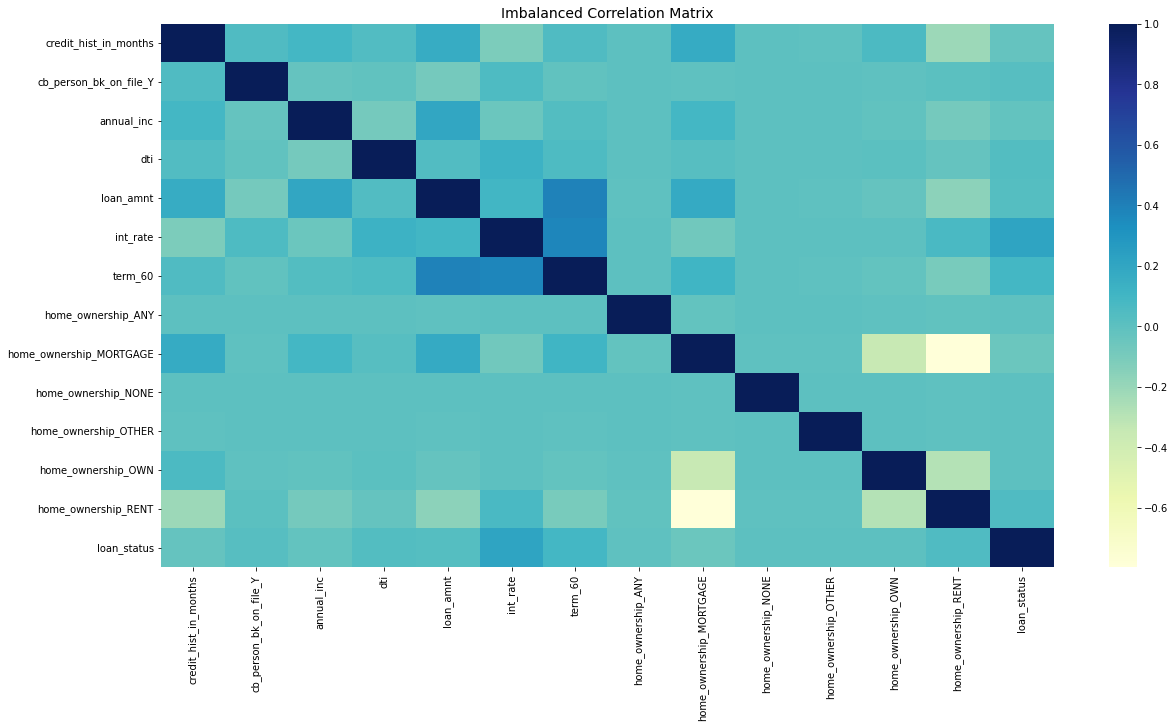

In [27]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))

# Imbalanced DataFrame Correlation
corr = processed_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

# Undersampling

The process where you randomly delete some of the observations from the majority class in order to match the numbers with the minority class

In [28]:
# Shuffle the Dataset.
random_data = processed_df.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
default_df = random_data.loc[random_data['loan_status'] == 1]

#Randomly select 297033 observations from the non-fraud (majority class)
non_default_df = random_data.loc[random_data['loan_status'] == 0].sample(n=297033, random_state=42)

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


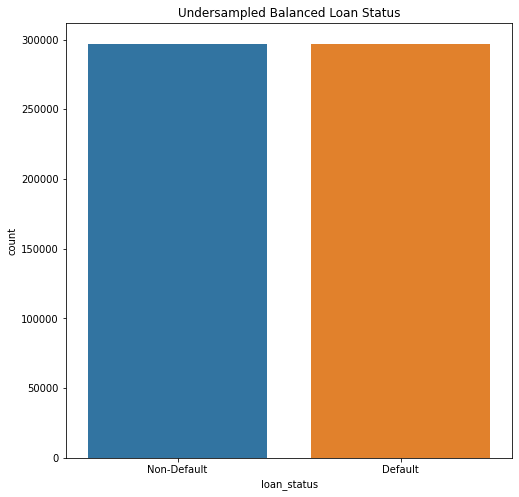

In [29]:
# Concatenate both dataframes again
US_df = pd.concat([default_df, non_default_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('loan_status', data=US_df)
plt.title('Undersampled Balanced Loan Status')
plt.xticks(ticks=(0,1), labels=('Non-Default', 'Default'))
plt.show()

In [30]:
# Create X and y using undersampled dataframe
X = US_df.drop(['loan_status', 'grade'], axis=1)
y = US_df['loan_status']

X_train_US, X_test_US, y_train_US, y_test_US = train_test_split(X, y, test_size=.4, random_state=123)

In [31]:
# Create, train, and fit a logistic regression model
from sklearn.linear_model import LogisticRegression
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train_US, np.ravel(y_train_US))

# Create predictions of probability for loan status using test data
# .predict_proba creates an array of probabilities of default: [[non-defualt, default]]
lr_preds = clf_logistic.predict_proba(X_test_US)

# # Create dataframes of predictions and true labels
lr_preds_df = pd.DataFrame(lr_preds[:,1][0:], columns = ['lr_pred_PD'])
true_df = y_test_US

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), lr_preds_df], axis = 1))

        loan_status  lr_pred_PD
0                 0    0.530770
1                 0    0.510444
2                 0    0.419373
3                 0    0.631293
4                 1    0.639652
...             ...         ...
237622            1    0.742460
237623            1    0.571265
237624            1    0.327558
237625            0    0.528750
237626            0    0.753022

[237627 rows x 2 columns]


In [32]:
# Reassign loan status based on the threshold and print the predictions
lr_preds_df['lr_pred_loan_status_60'] = lr_preds_df['lr_pred_PD'].apply(lambda x: 1 if x > 0.60 else 0)
print("Non-Default / Default predictions at 60% Threshhold: ")
print(lr_preds_df['lr_pred_loan_status_60'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 60% Threshhold: ")
print(confusion_matrix(y_test_US, lr_preds_df['lr_pred_loan_status_60']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test_US, lr_preds_df['lr_pred_loan_status_60'], target_names=target_names))

Non-Default / Default predictions at 60% Threshhold: 
0    176631
1     60996
Name: lr_pred_loan_status_60, dtype: int64
Confusion Matrix at 60% Threshhold: 
[[98568 20453]
 [78063 40543]]
              precision    recall  f1-score   support

 Non-Default       0.56      0.83      0.67    119021
     Default       0.66      0.34      0.45    118606

    accuracy                           0.59    237627
   macro avg       0.61      0.58      0.56    237627
weighted avg       0.61      0.59      0.56    237627



In [33]:
# Reassign loan status based on the threshold and print the predictions
lr_preds_df['lr_pred_loan_status_50'] = lr_preds_df['lr_pred_PD'].apply(lambda x: 1 if x > 0.50 else 0)
print("Non-Default / Default t predictions at 50% Threshhold: ")
print(lr_preds_df['lr_pred_loan_status_50'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 50% Threshhold: ")
print(confusion_matrix(y_test_US, lr_preds_df['lr_pred_loan_status_50']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test_US, lr_preds_df['lr_pred_loan_status_50'], target_names=target_names))

Non-Default / Default t predictions at 50% Threshhold: 
1    138916
0     98711
Name: lr_pred_loan_status_50, dtype: int64
Confusion Matrix at 50% Threshhold: 
[[62234 56787]
 [36477 82129]]
              precision    recall  f1-score   support

 Non-Default       0.63      0.52      0.57    119021
     Default       0.59      0.69      0.64    118606

    accuracy                           0.61    237627
   macro avg       0.61      0.61      0.60    237627
weighted avg       0.61      0.61      0.60    237627



# Plotting AUC for Logistic Regression Classification with Undersampled Data

0.6075193475488897


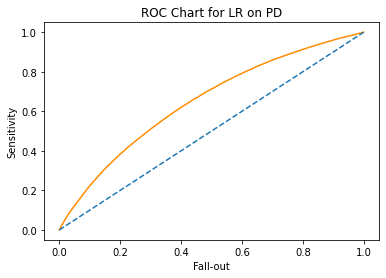

In [34]:
# Print the accuracy score the model
print(clf_logistic.score(X_test_US, y_test_US))

# Plot the ROC curve of the probabilities of default
from sklearn.metrics import roc_curve

lr_prob_default = lr_preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test_US, lr_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Chart for LR on PD")
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.show()

# Compute the AUC and store it in a variable
from sklearn.metrics import roc_auc_score

lr_auc = roc_auc_score(y_test_US, lr_prob_default)

# Modeling Five C's Portfolio Expected Loss using Balanced Bagging Classifier and XGB Classfier predicted probabilities of default

In [36]:
# Creating a portfolio datafram
portfolio_5c = pd.DataFrame(lr_preds[:,1][0:], columns = ['lr_prob_default'])
portfolio_5c.index = X_test_US.index
portfolio_5c['loan_amnt'] = X_test_US.loan_amnt
portfolio_5c.head()

,lr_prob_default,loan_amnt
1703960,0.530770,24000
222921,0.510444,32000
1001566,0.419373,8000
680612,0.631293,4225
1434838,0.639652,10000


In [37]:
# Create expected loss columns for each model using the formula

portfolio_5c['lr_expected_loss_1'] = portfolio_5c['lr_prob_default'] * 1 * portfolio_5c['loan_amnt']
portfolio_5c['lr_expected_loss_05'] = portfolio_5c['lr_prob_default'] * 0.5 * portfolio_5c['loan_amnt']
portfolio_5c['lr_expected_loss_01'] = portfolio_5c['lr_prob_default'] * 0.1 * portfolio_5c['loan_amnt']


# Print the total portfolio size
print('Portfolio size: $' + "{:,.2f}".format(np.sum(portfolio_5c['loan_amnt'])))

# Print the sum of the expected loss for bbc
print('LGD 100% expected loss: $' + "{:,.2f}".format(np.sum(portfolio_5c['lr_expected_loss_1'])))

# Print the sum of the expected loss for gbt
print('LGD 50% expected loss: $' + "{:,.2f}".format(np.sum(portfolio_5c['lr_expected_loss_05'])))

# Print the sum of the expected loss for lr 
print('LGD 10% expected loss: $' + "{:,.2f}".format(np.sum(portfolio_5c['lr_expected_loss_01'])))

# Print portfolio first five rows
portfolio_5c.head()

Portfolio size: $3,644,460,600.00
LGD 100% expected loss: $1,871,365,776.61
LGD 50% expected loss: $935,682,888.31
LGD 10% expected loss: $187,136,577.66


,lr_prob_default,loan_amnt,lr_expected_loss_1,lr_expected_loss_05,lr_expected_loss_01
1703960,0.530770,24000,12738.485698,6369.242849,1273.848570
222921,0.510444,32000,16334.223947,8167.111973,1633.422395
1001566,0.419373,8000,3354.982332,1677.491166,335.498233
680612,0.631293,4225,2667.212894,1333.606447,266.721289
1434838,0.639652,10000,6396.516702,3198.258351,639.651670
